# 2D channel with time-dependent boundary conditions

This example demonstrates a depth-averaged Thetis 2D simulation in a closed rectangular domain, where the flow is forced by an initial perturbation in the water elevation field centred in the middle of the channel. We add constant and time dependent boundary conditions. The model solves the Shallow Water Equations which are not expanded herein for brevity.
 
To run this example, it is necessary to install [firedrake](https://www.firedrakeproject.org/download.html) and [Thetis](https://thetisproject.org/download.html)

Note this is an extension of [2D channel example](https://github.com/thetisproject/thetis/blob/master/demos/demo_2d_channel.py). 

We begin by defining the domain and mesh:

In [1]:
from thetis import *
import pylab as plt

lx = 40e3
ly = 2e3
nx = 25
ny = 2
mesh2d = RectangleMesh(nx, ny, lx, ly)

plot(mesh2d)

We then define the bathymetry

In [2]:
P1_2d = FunctionSpace(mesh2d, 'CG', 1)
bathymetry_2d = Function(P1_2d, name='Bathymetry')
depth = 20.0
bathymetry_2d.assign(depth)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x109e3c940>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 41)

We are now ready to create a 2D solver object, and set some options. We start by specifying the duration of the simulation and the interval when we would like to get outputs.

In [3]:
# total duration in seconds
t_end = 12 * 3600
# export interval in seconds
t_export = 300.0

solver_obj = solver2d.FlowSolver2d(mesh2d, bathymetry_2d)
options = solver_obj.options
options.simulation_export_time = t_export
options.simulation_end_time = t_end
options.timestepper_type = 'CrankNicolson'
options.timestep = 50.0

We will force the model with a constant volume flux at the right boundary (x=40 km) and impose a tidal volume flux on the left boundary (x=0 km).

Note that ``t_end`` and ``t_export`` are large to better illustrate tidal dynamics.

Boundary conditions are defined for each external boundary using their ID.

In this example we are using a [RectangleMesh()](https://firedrakeproject.org/firedrake.html#firedrake.utility_meshes.RectangleMesh) which assigns IDs 1, 2, 3, and 4 for the four sides of the rectangle:

In [4]:
left_bnd_id = 1
right_bnd_id = 2

At each boundary we need to define the external value of the prognostic variables, i.e. in this case the water elevation and velocity.

The value should be either a Firedrake [Constant](https://firedrakeproject.org/firedrake.html#firedrake.constant.Constant) or [Function](https://firedrakeproject.org/firedrake.html#firedrake.function.Function) (in case the boundary condition is not uniform in space).

We store the boundary conditions in a dictionary:

In [5]:
swe_bnd = {}
in_flux = 1e3
swe_bnd[right_bnd_id] = {'elev': Constant(0.0),
                         'flux': Constant(-in_flux)}

Above we set the water elevation to zero and prescribe a constant volume flux. The volume flux is defined as outward normal flux, i.e. a negative value stands for flow into the domain. Alternatively we could also prescribe the normal velocity (with key ``'un'``) or the 2D velocity vector (``'uv'``).
For all supported boundary conditions, see module [shallowwater_eq](https://thetisproject.org/thetis.html#module-thetis.shallowwater_eq).

In order to set time-dependent boundary conditions we first define a python function that evaluates the time dependent variable:

Text(0.5,0,'t (sec)')

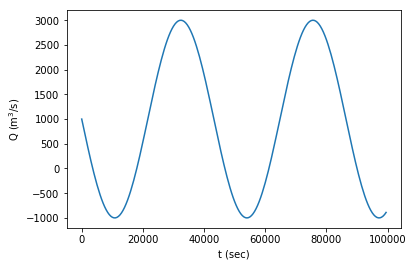

In [6]:
def timedep_flux(simulation_time):
    """Time-dependent flux function"""
    tide_amp = -2e3
    tide_t = 12 * 3600.
    flux = tide_amp*sin(2 * pi * simulation_time / tide_t) + in_flux
    return flux

plt.plot(np.arange(0,100000,500),[timedep_flux(i) for i in np.arange(0,100000,500)])
plt.ylabel('Q (m$^3$/s)')
plt.xlabel('t (sec)')

We then create a Constant object with the initial value, and assign it to the left boundary:

In [7]:
tide_flux_const = Constant(timedep_flux(0))
swe_bnd[left_bnd_id] = {'flux': tide_flux_const}

Boundary conditions are now complete, and we assign them to the solver object:

In [8]:
solver_obj.bnd_functions['shallow_water'] = swe_bnd

Note that if boundary conditions are not assigned for some boundaries (the lateral boundaries 3 and 4 in this case), Thetis assumes impermeable land conditions.

The only missing piece is to add a mechanism that re-evaluates the boundary condition as the simulation progresses. For this purpose we use the optional ``update_forcings`` argument of the [iterate()](https://thetisproject.org/thetis.html#thetis.solver2d.FlowSolver2d.iterate) method. ``update_forcings`` is a python function that updates all time dependent [Constant](https://firedrakeproject.org/firedrake.html#firedrake.constant.Constant)s or [Function](https://firedrakeproject.org/firedrake.html#firedrake.function.Function)s used to force the model. In this case we only need to update ``tide_flux_const``:

In [9]:
def update_forcings(t_new):
    """Callback function that updates all time dependent forcing fields"""
    tide_flux_const.assign(timedep_flux(t_new))

and finally pass this callback to the time iterator:

In [10]:
solver_obj.iterate(update_forcings=update_forcings)

Using default SIPG parameters
dt = 50.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm:     0.0000 u norm:     0.0000  0.00
    1     6 T=    300.00 eta norm:   107.6409 u norm:    75.3292  1.57
    2    12 T=    600.00 eta norm:   147.2090 u norm:   103.1224  0.07
    3    18 T=    900.00 eta norm:   174.1495 u norm:   122.0760  0.07
    4    24 T=   1200.00 eta norm:   194.0911 u norm:   136.0650  0.07
    5    30 T=   1500.00 eta norm:   199.4830 u norm:   153.3989  0.07
    6    36 T=   1800.00 eta norm:   164.2006 u norm:   186.7958  0.07
    7    42 T=   2100.00 eta norm:   131.9381 u norm:   209.3091  0.08
    8    48 T=   2400.00 eta norm:   103.1535 u norm:   225.1220  0.08
    9    54 T=   2700.00 eta norm:    82.2990 u norm:   235.6943  0.08
   10    60 T=   3000.00 eta norm:    95.1048 u norm:   233.2075  0.09
   11    66 T=   3300.00 eta norm:   115.0204 u norm:   209.2409  0.07
   12    72 T=   3600.00 eta norm:   144.0432 u norm:   189.4889  0.07


  115   690 T=  34500.00 eta norm:   566.0024 u norm:   673.1975  0.07
  116   696 T=  34800.00 eta norm:   561.1987 u norm:   670.4143  0.07
  117   702 T=  35100.00 eta norm:   555.3449 u norm:   666.7849  0.09
  118   708 T=  35400.00 eta norm:   548.4528 u norm:   662.3162  0.07
  119   714 T=  35700.00 eta norm:   540.5361 u norm:   657.0167  0.07
  120   720 T=  36000.00 eta norm:   531.6112 u norm:   650.8967  0.07
  121   726 T=  36300.00 eta norm:   521.6962 u norm:   643.9679  0.06
  122   732 T=  36600.00 eta norm:   510.8116 u norm:   636.2439  0.09
  123   738 T=  36900.00 eta norm:   498.9801 u norm:   627.7395  0.07
  124   744 T=  37200.00 eta norm:   486.2264 u norm:   618.4713  0.08
  125   750 T=  37500.00 eta norm:   472.5775 u norm:   608.4571  0.08
  126   756 T=  37800.00 eta norm:   458.0626 u norm:   597.7166  0.08
  127   762 T=  38100.00 eta norm:   442.7132 u norm:   586.2706  0.09
  128   768 T=  38400.00 eta norm:   426.5630 u norm:   574.1414  0.07
  129 

While the model is running, Thetis prints some statistics on the command line:
 
    0     0 T=      0.00 eta norm:     0.0000 u norm:     0.0000  0.00
    1     6 T=    300.00 eta norm:   107.6409 u norm:    75.3292  1.57
    2    12 T=    600.00 eta norm:   147.2090 u norm:   103.1224  0.08
    3    18 T=    900.00 eta norm:   174.1495 u norm:   122.0760  0.07
     ...
 
 The first column is the export index, the second one the number of executed
 time steps, followed by the simulation time. ``eta norm`` and ``u norm`` are
 the L2 norms of the elevation and depth averaged velocity fields, respectively.
 The last column stands for the (approximate) wall-clock time between exports.
 
 The simulation terminates once the end time is reached.
 See the [outputs and visualization page](https://thetisproject.org/outputs_and_visu.html)  on how to
 visualize the results.

The resultant velocity and elevation fields are shown below:

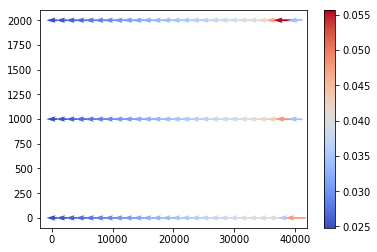

In [11]:
plot(solver_obj.fields.uv_2d)

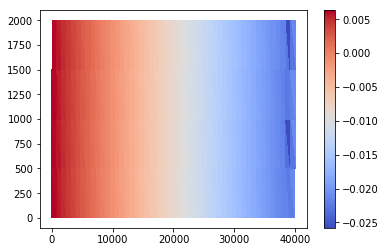

In [12]:
plot(solver_obj.fields.elev_2d)